# Computational Geometry in Python
reference: 'Discrete and Computational Geometry' (2011) Devadoss and O'Rourke.

In [140]:
%load_ext autoreload
%autoreload 2

import triangle
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import cPickle as pickle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Introduction: What is Computational Geometry? Why is it important?

## 2) Polygons

### 2.1 Definition: 
"A polygon is the closed region of the plane bounded by a finite collection of line segments forming a closed curve that does not intersect itself."

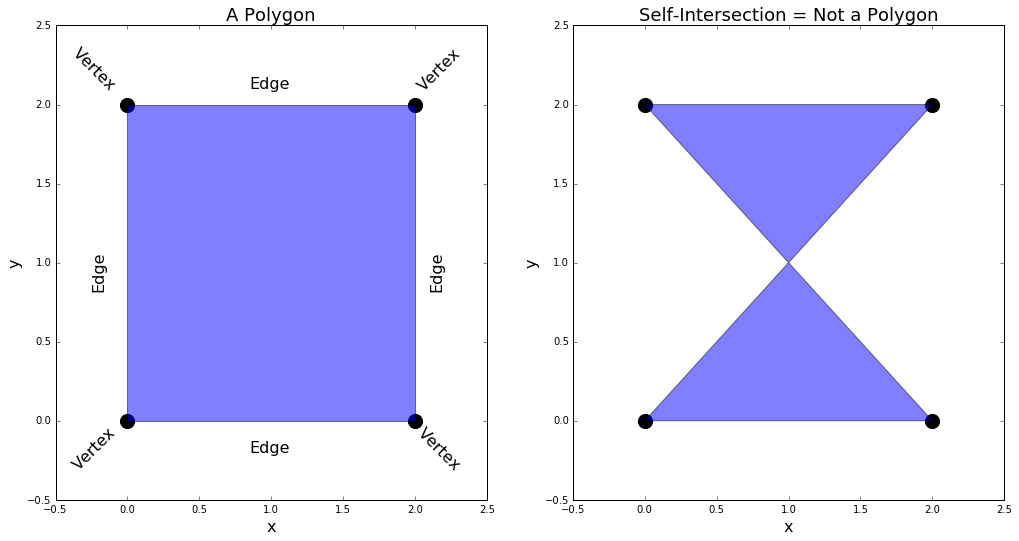

In [2]:
#plot an example of a polygon and an object that fails to be a polygon


fig_2_1 = matplotlib.pyplot.figure()

polygon_vertices = np.array([[0,2], #top left
                             [2,2], #top right
                             [2,0], #bottom right
                             [0,0]]) #bottom left

self_intersection_vertices = np.array([[0,2], #top left
                                       [2,2], #top right
                                       [0,0], #bottom left
                                       [2,0]]) #bottom right

ax = fig_2_1.add_subplot(121)
ax.scatter(polygon_vertices[...,0], polygon_vertices[...,1], color='black', s=200, label = 'vertices')
polygon = Polygon(polygon_vertices, alpha = 0.5)
ax.add_patch(polygon)
ax.set_title('A Polygon', fontsize=18)

ax2 = fig_2_1.add_subplot(122)
ax2.scatter(self_intersection_vertices[...,0], self_intersection_vertices[...,1], color='black', s=200, label = 'vertices')
polygon = Polygon(self_intersection_vertices, alpha = 0.5)
ax2.add_patch(polygon)
ax2.set_title('Self-Intersection = Not a Polygon', fontsize=18)

for axis in [ax,ax2]:
    axis.set_xlabel('x', fontsize = 16)
    axis.set_ylabel('y', fontsize = 16)

#some text labels for the polygon case
ax.text(0.85,2.1,'Edge', fontsize = 16)
ax.text(0.85,-0.2,'Edge', fontsize = 16)
ax.text(-0.25,1.0,'Edge', fontsize = 16, rotation=90)
ax.text(2.1,1.0,'Edge', fontsize = 16, rotation=90)
ax.text(-0.4,2.3,'Vertex', fontsize = 16, rotation=-45)
ax.text(2.0,2.3,'Vertex', fontsize = 16, rotation=45)
ax.text(-0.4,-0.1,'Vertex', fontsize = 16, rotation=45)
ax.text(2.0,-0.1,'Vertex', fontsize = 16, rotation=-45)

fig_2_1.set_size_inches(17,8.5)

### 2.2 Every Polygon Has A Triangulation:

Some useful definitions:
    
1. **Diagonal**: a line segment connecting two vertices of P and lying in the interior of P, not touching $\partial$P except at its endpoints
2. **Triangulation**: a decomposition of P into triangles by a maximal set of noncrossing diagonals

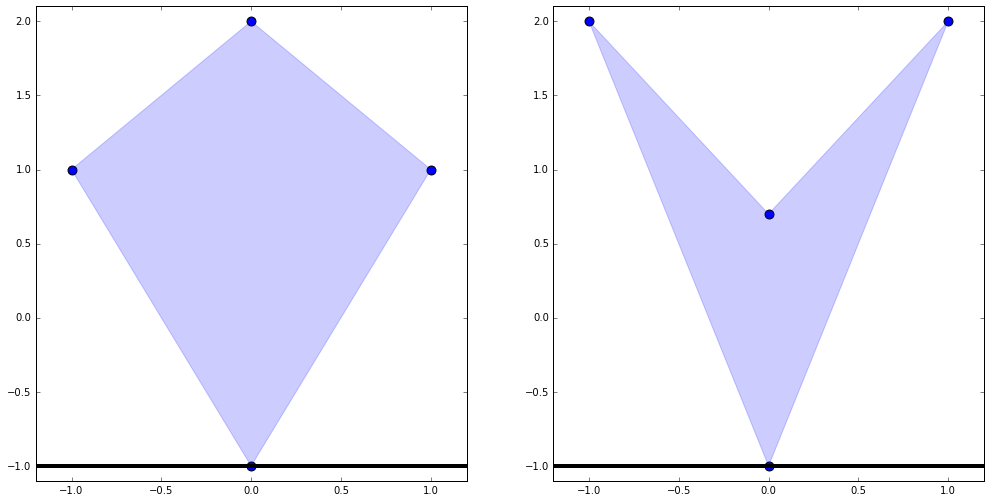

In [3]:
@interact(y_value_p1 = widgets.FloatSlider(min=-1,max=2.1,step=0.1,value=-1),
          y_value_p2 = widgets.FloatSlider(min=-1,max=2.1,step=0.1,value=-1),
          new_diagonal_p2 = False)
def polygon_sweep(y_value_p1, y_value_p2, new_diagonal_p2):
    fig_2_2 = matplotlib.pyplot.figure()
    fig_2_2.set_size_inches(17,8.5)

    polygon_1 = np.array([[0,2],#top
                          [-1,1],#left
                          [0,-1], #bottom
                          [1,1]])#right

    polygon_2 = np.array([[0,0.7],#top
                          [-1,2],#left
                          [0,-1],#bottom
                          [1,2]])#right

    ax1 = fig_2_2.add_subplot(121)
    p1 = Polygon(polygon_1, color='blue', alpha = 0.2)
    ax1.add_patch(p1)
    ax1.scatter(polygon_1[...,0], polygon_1[...,1], s=80)
    ax2 = fig_2_2.add_subplot(122)
    p2 = Polygon(polygon_2, color='blue', alpha = 0.2)
    ax2.add_patch(p2)
    ax2.scatter(polygon_2[...,0], polygon_2[...,1], s=80)

    for axis in [ax1,ax2]:
        axis.set_xlim(-1.2,1.2)
        axis.set_ylim(-1.1,2.1)
    ax1.axhline(y=y_value_p1, lw=4, color = 'black')
    ax2.axhline(y=y_value_p2, lw=4, color = 'black')
    if new_diagonal_p2:
        ax2.axvline(x=0,ymin=0.03,ymax=0.55,color='green',lw=4)

### 2.3 Every triangulation of a polygon with n vertices has n - 2 triangles

Although we will deal with triangulations in greater detail later, here we will use a specific type of triangulation (a **constrained** triangulation) available in the award-winning **Triangle** library to see a demonstration of the above property on some interesting polygons. The Python bindings were written by Dzhelil Rufat--the original **Triangle** library was written by Jonathan Shewchuk (Prof. at UC Berkeley).

In [4]:
import shapefile #Python pyshp library
sf = shapefile.Reader("shapefiles/cb_2015_us_state_20m.shp") #a pain to figure out where / how to download these from Government websites
shapeRecs = sf.shapeRecords()
for shapeRec in shapeRecs:
    if 'Oregon' in shapeRec.record:
        Oregon_vertices = np.array(shapeRec.shape.points)
        
#filter out roughly co-linear points for the purpose of the Triangle library (otherwise get segfault problems)
rows_to_keep = []
index = 0
while index < Oregon_vertices.shape[0] - 1:
    current_x_coord = Oregon_vertices[index,0]
    current_y_coord = Oregon_vertices[index,1]
    next_x_coord = Oregon_vertices[index + 1,0]
    next_y_coord = Oregon_vertices[index + 1,1]
    if abs(current_x_coord - next_x_coord) < 0.001 or abs(current_y_coord - next_y_coord) < 0.001:
        index += 1
        continue
    else:
        rows_to_keep.append(index)
        index += 1
        
Oregon_vertices = Oregon_vertices[rows_to_keep]
Oregon_vertices.shape

(214, 2)

In [5]:
def generate_regular_polygon_vertices(r, n_vertices):
    iteration_values = np.arange(n_vertices)
    angles = 2 * math.pi * iteration_values / float(n_vertices)
    x_coords = r * np.cos(angles)
    y_coords = r * np.sin(angles)
    polygon_coords = np.stack((x_coords, y_coords), axis=-1)
    return polygon_coords

#generate the 65537-gon, which Hermes worked on for 10 years in a 200-page manuscript
polygon_Hermes = generate_regular_polygon_vertices(1.0, 65537)
polygon_Hermes.shape

(65537, 2)

Oregon_vertices.shape: (214, 2)
Oregon num triangles: (212, 3)
65537-gon num triangles: (65535, 3)


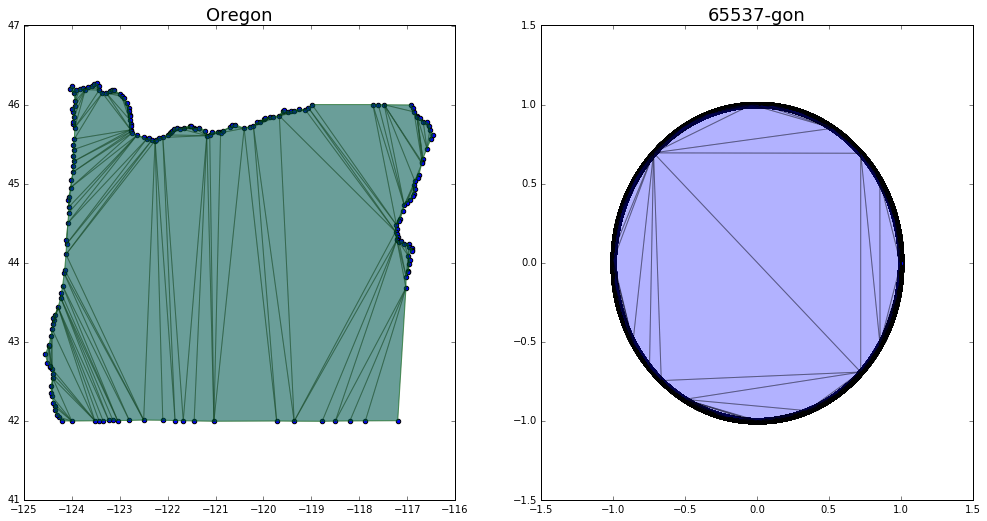

In [6]:
#plot the polygons of interest with interactive widget(s) for triangulation, etc.
from matplotlib.collections import PolyCollection

@interact(triangulate_Oregon= False,
          triangule_Hermes = False)
def triangulation_demo(triangulate_Oregon=False, triangulate_Hermes=False):
    fig_2_3 = plt.figure()
    ax1 = fig_2_3.add_subplot(121)
    ax1.scatter(Oregon_vertices[...,0], Oregon_vertices[...,1])
    p_Oregon = Polygon(Oregon_vertices, color='green', alpha = 0.4)
    ax1.add_patch(p_Oregon)
    ax1.set_title('Oregon', fontsize=18)
    ax2 = fig_2_3.add_subplot(122)
    ax2.scatter(polygon_Hermes[...,0], polygon_Hermes[...,1])
    ax2.set_title('65537-gon', fontsize=18)
    fig_2_3.set_size_inches(17,8.5)
    
    if triangulate_Oregon:
        #need vertex indices for all edges of the polygon
        segment_start_indices = np.arange(Oregon_vertices.shape[0])
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        print 'Oregon_vertices.shape:', Oregon_vertices.shape
        Oregon_vertex_dict = dict(vertices = Oregon_vertices, segments = segment_indices)
        tri = triangle.triangulate(Oregon_vertex_dict, 'p') #'p' for triangulation of planar graph
        print 'Oregon num triangles:', tri['triangles'].shape
        simplex_coords = Oregon_vertices[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.3)
        ax1.add_collection(triangles)
        
    if triangulate_Hermes:
        segment_start_indices = np.arange(polygon_Hermes.shape[0])
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        Hermes_vertex_dict = dict(vertices = polygon_Hermes, segments = segment_indices)
        tri = triangle.triangulate(Hermes_vertex_dict, 'p') #'p' for triangulation of planar graph
        print '65537-gon num triangles:', tri['triangles'].shape
        simplex_coords = polygon_Hermes[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.3)
        ax2.add_collection(triangles)
        
        
        
        

###  2.4 The Catalan Number

**Convex Polygon**: every pair of nonadjacent vertices determines a diagonal

**Catalan Number**: the number of triangulations of a convex polygon with n + 2 vertices 

$$C_n = \frac{(2n)!}{(n+1)!n!}$$

In [8]:
def catalan_number(num_vertices):
    n = num_vertices - 2
    Catalan = math.factorial(2 * n) / (math.factorial(n + 1) * math.factorial(n))
    return Catalan

In [9]:
#How many triangulations are possible for the 65537-gon?
triangulation_count_Hermes = catalan_number(65537)
triangulation_count_Hermes

3374732320144055611333805616298558835783787508671925452920477605636388984490555771373904834011799611035292170040895110091943394091576949946240742800475201138300641965796314401404247928180484701557282673372362316442905744089878153279759786981548427107571744468457066268239496340820862909908071574597277294600629610649935488729969440293631975310704555739174044586343916064826200114187245205039658894882446525997516320030303864005643071465005913345079626189103228459801785413012870529522632677154599825550459558196490378747242375045720685725991350418930468493964012549693969116419807930764952596060320863106731797566608749979397158741729692432614821999196840200773270804819430838563976579506208674661717426847254302386602424851135108372620945060355588638062691605201385944751990299334888779693231434527689130753848473642168782539162864080947884081330557868257492643300360170246347285291104360848363041861542700388018274733159367931541719203948212353356971948300044025096875417622554932695078504209869961

In [10]:
#Ok, that's a lot of possible triangulations! For a square there should only be two possibilities:
triangulation_count_square = catalan_number(4)
triangulation_count_square

2

So, that looks sensible (though the derivation is non-trivial for me!) and could be a useful i.e., unit test in some circumstances. It is not so simple to deal with the possible triangulations of non-convex polygons, but convex polygons have the most triangulations, so the total permutations are always between 1 and the catalan number--for *any* polygon.

### 2.5 The Art Gallery Problem

The problem posed by Victor Klee in 1973: what is the fewest number of (stationary) guards (capable of 360 degree vision) placed anywhere inside a polygon that would have sufficient line of sight coverage to cover the entire polygon interior?

Many versions of the posed problem are NP-hard! It has been firmly established that floor($\frac{n}{3}$) guards  are always sufficient and sometimes necessary to guard a polygon with n vertices. Protecting the exterior (the *Fortress Problem*) is more difficult--ceiling($\frac{n}{2}$) guards are always sufficient and sometimes necessary to cover the exterior of any given polygon.

#### Examples

In [11]:
#A Pentagon
max_guards_pentagon = math.floor(5./3.)
max_fortress_pentagon = math.ceil(5./2.)
max_guards_pentagon, max_fortress_pentagon

(1.0, 3.0)

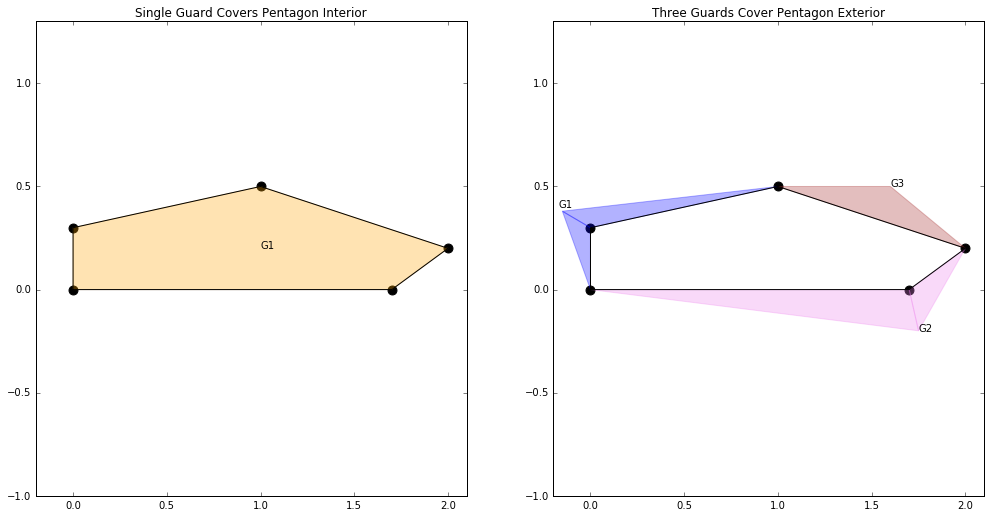

In [12]:
pentagon_coords = np.array([[0,0],#bottom left
                            [0,0.3],#top left
                            [1.0,0.5],#top
                            [2.0,0.2],#right
                            [1.7,0.0]]) #bottom right
fig_2_5 = plt.figure()
ax = fig_2_5.add_subplot(121)
p = Polygon(pentagon_coords, color='orange', alpha = 0.3)
ax.text(1.0,0.2,'G1')
closed_polygon_coords = np.zeros((6,2))
closed_polygon_coords[:-1,...] = pentagon_coords
closed_polygon_coords[-1, ...] = pentagon_coords[0,...]
ax.add_patch(p)
ax.set_title('Single Guard Covers Pentagon Interior')
ax2 = fig_2_5.add_subplot(122)

for axis in [ax,ax2]:
    axis.set_xlim(-0.2,2.1)
    axis.set_ylim(-1,1.3)
    axis.plot(closed_polygon_coords[...,0], closed_polygon_coords[...,1], c = 'black')
    axis.scatter(pentagon_coords[...,0], pentagon_coords[...,1], c = 'black', s=80)

ax2.set_title('Three Guards Cover Pentagon Exterior')
ax2.text(-0.17,0.4, 'G1')
ax2.text(1.75,-0.2, 'G2')
ax2.text(1.6,0.5, 'G3')

#draw the lines of sight for the the guards using triangles
g1_t1 = Polygon(np.concatenate((np.array([[-0.15,0.38]]),pentagon_coords[0:2])), color='blue', alpha = 0.3)
g1_t2 = Polygon(np.concatenate((np.array([[-0.15,0.38]]),pentagon_coords[1:3])), color='blue', alpha = 0.3)
ax2.add_patch(g1_t1)
ax2.add_patch(g1_t2)
g2_t1 = Polygon(np.concatenate((np.array([[1.75,-0.2]]),np.array([closed_polygon_coords[-2]]),np.array([closed_polygon_coords[0]]))), color='violet', alpha = 0.3)
g2_t2 = Polygon(np.concatenate((np.array([[1.75,-0.2]]),np.array([closed_polygon_coords[-2]]),np.array([closed_polygon_coords[-3]]))), color='violet', alpha = 0.3)
ax2.add_patch(g2_t1)
ax2.add_patch(g2_t2)
g3_t1 = Polygon(np.concatenate((np.array([[1.6,0.5]]),np.array([closed_polygon_coords[-3]]),np.array([closed_polygon_coords[-4]]))), color='brown', alpha = 0.3)
ax2.add_patch(g3_t1)

fig_2_5.set_size_inches(17, 8.5)

In the above case the upper bounds for guarding the interior and exterior of the pentagon also appear to be the optimal solutions. It is useful to have these boundaries to assess i.e., if the number of guards you have suggested for a given polygon is within the theoretical upper limit.

However, given an arbitrary polygon and a suggested number of guards, determining if said polygon can be covered by that number of guards is generally NP-hard. As a simple example of the dissociation of the number of sufficient guards (no more than this number are ever required for a given polygon of n vertices) and the minimum number required to cover a given polygon, let's consider hexagons.

In [13]:
#Hexagon Art Gallery
max_guards_hexagon = math.floor(6./3.)
max_guards_hexagon

2.0

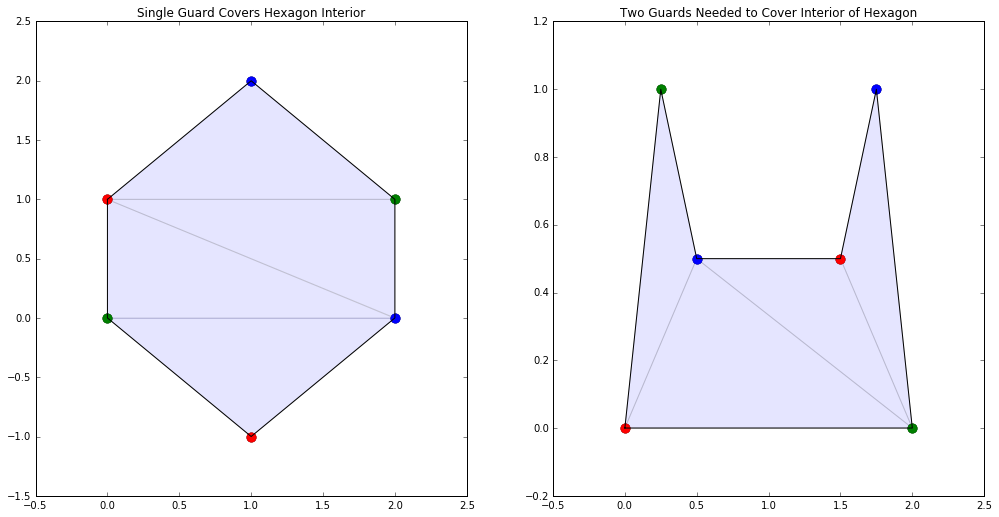

In [14]:
#demonstrate hexagons that require 1 or 2 guards with triangulation overlays
@interact(Fisk1=False,
          Fisk2=False)
def hexagon_demonstration(Fisk1=False,Fisk2=False):
    hexagon_1 = np.array([[0,1],#top left
                         [1,2],#top
                         [2,1],#top right
                         [2,0],#bottom right
                         [1,-1],#bottom
                         [0,0]])#bottom left
    fig_hex = plt.figure()
    fig_hex.set_size_inches(17,8.5)
    ax1 = fig_hex.add_subplot(121)
    ax1.scatter(hexagon_1[...,0], hexagon_1[...,1],c='black',s=80)
    closed_polygon_coords = np.zeros((7,2))
    closed_polygon_coords[:-1,...] = hexagon_1
    closed_polygon_coords[-1, ...] = hexagon_1[0,...]
    ax1.plot(closed_polygon_coords[...,0], closed_polygon_coords[...,1], c='black')
    ax1.set_title('Single Guard Covers Hexagon Interior')

    hexagon_2 = np.array([[0,0],#bottom left
                          [0.25,1],#top left
                          [0.5,0.5], #left
                          [1.5,0.5], #right
                          [1.75,1],#top right
                          [2,0]]) #bottom right
    
    ax2 = fig_hex.add_subplot(122)
    ax2.scatter(hexagon_2[...,0], hexagon_2[...,1],c='black',s=80)
    ax2.set_title('Two Guards Needed to Cover Interior of Hexagon')
    closed_polygon_coords = np.zeros((7,2))
    closed_polygon_coords[:-1,...] = hexagon_2
    closed_polygon_coords[-1, ...] = hexagon_2[0,...]
    ax2.plot(closed_polygon_coords[...,0], closed_polygon_coords[...,1], c='black')
    
    if Fisk1:
        #constrained triangulation of the first hexagon:
        segment_start_indices = np.arange(6)
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        hexagon_1_vertex_dict = dict(vertices = hexagon_1, segments = segment_indices)
        tri = triangle.triangulate(hexagon_1_vertex_dict, 'p') 
        simplex_coords = hexagon_1[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.1)
        ax1.add_collection(triangles)
        #use colour scheme from Steve Fisk's proof of the floor(n/3) limit
        colours = ['red','blue','green','blue','red','green'] 
        for vertex in hexagon_1:
            ax1.scatter(vertex[0], vertex[1], color=colours.pop(0), s=81)

    if Fisk2:
        #constrained triangulation of the second hexagon:
        segment_start_indices = np.arange(6)
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        hexagon_2_vertex_dict = dict(vertices = hexagon_2, segments = segment_indices)
        tri = triangle.triangulate(hexagon_2_vertex_dict, 'p') 
        simplex_coords = hexagon_2[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.1)
        ax2.add_collection(triangles)
        #use colour scheme from Steve Fisk's proof of the floor(n/3) limit
        colours = ['red','green','blue','red','blue','green'] 
        for vertex in hexagon_2:
            ax2.scatter(vertex[0], vertex[1], color=colours.pop(0), s=81)

The minimum count of the colours is the sufficient number of guards to guarantee internal coverage, but less guards can be used in some cases.

Once again, the 3D case is more complicated because not all polyhedra can be tetrahedralized. Indeed, even placing a guard at every single vertex of the polyhedron does not necessarily guarantee full coverage.

## 3) Convex Hulls (and transition to point sets)

### 3.1 Convexity, Convex Hulls and General Position

**Convex Regions**: a region is convex if any two points of the region are visible to one another within the region. The **convex hull** is the smallest convex region containing the point set *S*.

**Convex Hull by Example -- Back to Kindergarden Geoboards**
![Geoboard](images/geoboard.jpg)

**Calculate it yourself with the incredibly-useful `scipy.spatial` library**

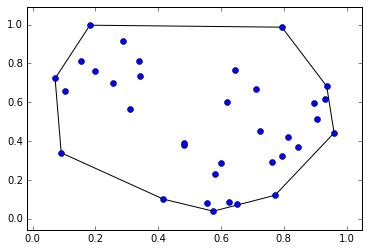

In [15]:
#a simple example of the convex hull for a random set of points in the plane
random_2D_array = np.random.random_sample((35,2))
hull = scipy.spatial.ConvexHull(random_2D_array)
sample_hull_plot = scipy.spatial.convex_hull_plot_2d(hull)

Prerequisites: **General Position**

A set of points (or other geometric objects) are said to be in **general position** if they avoid troublesome configurations, known as *degenerate* situations. The precise definition of **general position** varies depending on the algorithm. A point set is always in general position if the n points are chosen randomly, but this is (of course) not the case with real world data.

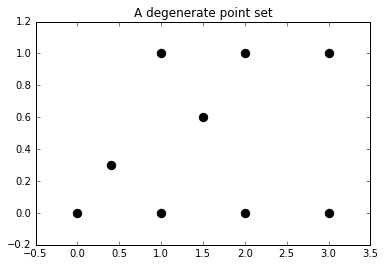

In [17]:
#produce an example of a degenerate point set:
fig_degenerate = plt.figure()
degenerate_vertices = np.array([[0,0],
                                [1,0],
                                [2,0],
                                [3,0],
                                [3,1],
                                [2,1],
                                [1,1],
                                [1.5,0.6],
                                [0.4,0.3]])
ax = fig_degenerate.add_subplot(111)
ax.scatter(degenerate_vertices[...,0], degenerate_vertices[...,1], c='k', s=70)
ax.set_title('A degenerate point set')

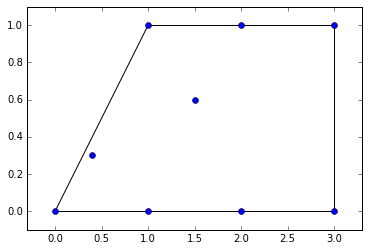

In [18]:
#try calculating the convex hull of the above point set
hull = scipy.spatial.ConvexHull(degenerate_vertices, qhull_options='Qc')
plot = scipy.spatial.convex_hull_plot_2d(hull)

In [19]:
hull.coplanar #the above computation is possible because Qhull is able to ignore a subset of the pathological input points (their indices and neighbour indices are only computed with the additional 'Qc' option sent to Qhull)

array([[2, 0, 3],
       [1, 0, 0],
       [5, 3, 6]], dtype=int32)

In this case the algorithm actually handles the potentially pathological collinear data, but it is important to note that this kind of data could typically cause issues.

### 3.2 Practical Algorithm Time & Space Complexities

Convex Hull algorithms are fundamental to computational geometry and it is useful to have a working knowledge of the terminology used to describe their performance.

Complexity analysis captures the speed of an algorithm as a function of data input size using *Big-Oh* notation.

For a specific algorithm and an input of size $n$, the running time is captured as $O(f(n))$, and $cf(n)$ is the upper bound on the running time of the algorithm, where $c>0$ is a constant. The upper bound means that we typically ignore lower values of $n$ and focus on the asymptotic 'worst-case' scenarios.

Selected Examples:

| big-Oh notation | name | Example | 
|-----------------|-------------|---|
|$O(1)$ | Constant | Adding two numbers
|$O(n \textrm{ log } n)$ | loglinear | Sorting a list
|$O(n^2)$ | Quadratic | Incremental convex hull algorithm
|$O(n^k)$ | Polynomial | Robot Arm Motion Planning
|$O(c^n)$ | Exponential | Some Brute Force Algorithms


We focus on **time complexity**, but there are also cases where memory usage (**space complexity**) is critical for an algorithm.

### 3.3 Determine the time complexity of the `ConvexHull` algorithm used by `scipy.spatial` (which is actually just a wrapper for the popular `qhull` package)

In [20]:
#we will use an empirical approach, although an expert could study the algorithm / source code and identify the 'rate-limiting' step based on the type of operations performed
import time

def linear(n, m, c):
    return m * n + c

def loglinear(n, m, c):
    return m * (n * np.log(n)) + c

def quadratic(n, m, c):
    return m * (n ** 2) + c

points_list = [1000,20000,30000,50000,70000,100000,200000,300000,500000,700000,900000,1000000]
list_times = []

for num_points in points_list:
    random_2D_points = np.random.random_sample((num_points,2))
    start_time = time.time()
    hull = scipy.spatial.ConvexHull(random_2D_points)
    elapsed_time = time.time() - start_time
    list_times.append(elapsed_time)
    print 'benchmarked', num_points, 'points in:', elapsed_time, ' seconds'

benchmarked 1000 points in: 0.000377178192139  seconds
benchmarked 20000 points in: 0.00272917747498  seconds
benchmarked 30000 points in: 0.00388503074646  seconds
benchmarked 50000 points in: 0.00719809532166  seconds
benchmarked 70000 points in: 0.00980806350708  seconds
benchmarked 100000 points in: 0.0130288600922  seconds
benchmarked 200000 points in: 0.0256378650665  seconds
benchmarked 300000 points in: 0.0381619930267  seconds
benchmarked 500000 points in: 0.0684020519257  seconds
benchmarked 700000 points in: 0.0890040397644  seconds
benchmarked 900000 points in: 0.116715908051  seconds
benchmarked 1000000 points in: 0.13622713089  seconds


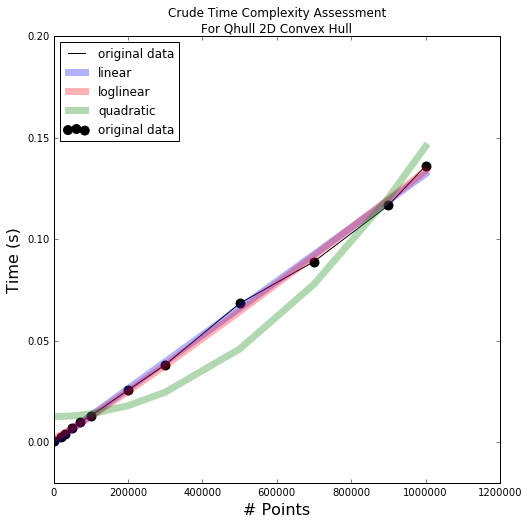

In [21]:
import scipy.optimize
popt, pcov = scipy.optimize.curve_fit(linear, points_list, list_times)
linear_y_data = linear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(loglinear, points_list, list_times)
loglinear_y_data = loglinear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(quadratic, points_list, list_times)
quadratic_y_data = quadratic(np.array(points_list), popt[0], popt[1])

fig_bench_hull = plt.figure()
ax = fig_bench_hull.add_subplot(111)
ax.scatter(points_list, list_times, c='k', label='original data', s = 80)
ax.plot(points_list, list_times, c='k', label='original data')

ax.plot(points_list, linear_y_data, c = 'blue', lw=7,alpha = 0.3, label = 'linear')
ax.plot(points_list, loglinear_y_data, c = 'red', lw=7,alpha = 0.3, label = 'loglinear')
ax.plot(points_list, quadratic_y_data, c = 'green', lw=7,alpha = 0.3, label = 'quadratic')
ax.legend(loc=2)

ax.set_title('Crude Time Complexity Assessment\nFor Qhull 2D Convex Hull')
ax.set_xlim(-50,1.2e+6)
ax.set_ylim(-0.02,0.20)
ax.set_xlabel('# Points',fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
fig_bench_hull.set_size_inches(8,8)


    

Qhull implements the Quickhull algorithm for convex hull [Barber et al. '96]. It has output-sensitive performance that can slightly improve on loglinear in some cases.

While the above Qhull algorithm is highly specialized / optimized and works well across several dimensions, a more straightforward summary of general Convex Hull algorithm performance is shown below:


Paradigm | 2D Complexity | 3D Complexity | Notes
---------|---------------|---------------|-------
Incremental | $O(n^2)$ | $O(n^2)$| often implemented because of conceptual simplicity
Gift-wrapping | $O(nh)$ | $O(nf)$| 
Graham scan | $O(n\:{\log}\:n)$ | N/A |
divide-and-conquer (recursion) | $O(n\:{\log}\:n)$ | $O(n\:{\log}\:n)$| 4D and up: $\Omega(n^{d/2})$





#### 3.3.1 Can the Python community do better than `scipy.spatial.ConvexHull`?

**NO**, not from an algorithmic standpoint, because loglinear performance is the lower bound on sorting operations and we can reduce the convex hull problem (in the simplest case) to a sorting problem for a parabola:

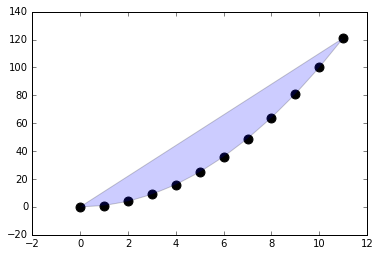

In [22]:
x = np.arange(12)
y = x ** 2
fig_hull = plt.figure()
ax = fig_hull.add_subplot(111)
ax.scatter(x,y,s=80,c ='k')
closed_parabola = np.zeros((x.shape[0] + 1,2))
closed_parabola[:-1,0] = x
closed_parabola[:-1,1] = y
closed_parabola[:-1] = np.array(x[0],y[0])
parabola = np.array(zip(x,y))
p = Polygon(parabola, alpha = 0.2)
ax.add_patch(p)


It turns out that, even if we didn't care about connectivity (i.e., only wanted the hull points without their order), the fastest possible performance is still loglinear. This was discovered relatively recently (1985) by Franco Preparata and Michael Shamos.

###  3.4 Practical Examples with `scipy.spatial.ConvexHull`

#### 3.4.1 2D

Problem: Let's say you have a startup that built a long-distance robot that you'd like to send along land from the far West of Oregon to its Eastern Border. However, a sufficient number of Oregon residents have objected to this project such that a straight line through the State will not be possible. Instead, you decide to treat the entire area of Oregon as hazardous for the robot, planning to travel on the borders (or in the more permissive neibhouring States) only. Assuming flat terrain, find the minimum total distance that may be traveled by the robot from the Westernmost point of Oregon to its Easternmost point. 

In [69]:
#determine the indices of the West / East limit points (which also fall on the convex hull, by definition):
x_min_index = np.argmin(Oregon_vertices[...,0])
x_max_index = np.argmax(Oregon_vertices[...,0])
x_min_index, x_max_index

(0, 137)

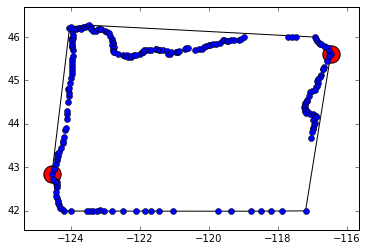

In [70]:
#confirm positions of the West/ East limits in the context of the state and its convex hull
x_min_coord = Oregon_vertices[0]
x_max_coord = Oregon_vertices[137]
fig_Oregon_limits = plt.figure()
ax = fig_Oregon_limits.add_subplot(111)
ax.scatter(x_min_coord[0], x_min_coord[1], c='red', s = 300)
ax.scatter(x_max_coord[0], x_max_coord[1], c='red', s = 300)

hull = scipy.spatial.ConvexHull(Oregon_vertices)
hull_plot = scipy.spatial.convex_hull_plot_2d(hull, ax)

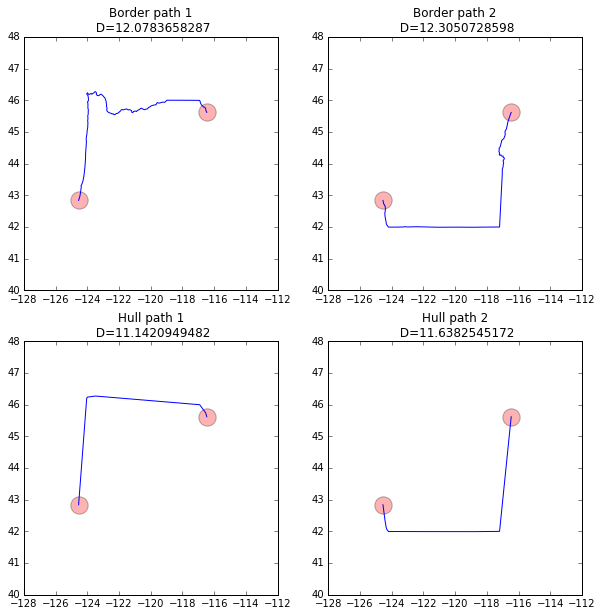

In [125]:
#plot and assess travel distance for the 2 possible border paths and 2 possible Convex Hull paths:
fig_Oregon_paths = plt.figure()
fig_Oregon_paths.set_size_inches(10,10)

ax_border_1 = fig_Oregon_paths.add_subplot(221)
ax_border_1.plot(Oregon_vertices[:138, 0], Oregon_vertices[:138, 1])
dist_1 = np.diag(scipy.spatial.distance_matrix(Oregon_vertices[:137],Oregon_vertices[1:138])).sum()
ax_border_1.set_title('Border path 1\n D={dist}'.format(dist=dist_1))

ax_border_2 = fig_Oregon_paths.add_subplot(222)
cycled_array = np.concatenate((Oregon_vertices,np.array([Oregon_vertices[0,...]])))
ax_border_2.plot(cycled_array[137:, 0], cycled_array[137:, 1])
dist_2 = np.diag(scipy.spatial.distance_matrix(cycled_array[137:-1],cycled_array[138:])).sum()
ax_border_2.set_title('Border path 2\n D={dist}'.format(dist=dist_2))

#note: in 2D scipy returns hull coords in CCW order
hull_coords = hull.points[hull.vertices]
hull_min_index = np.argmin(hull_coords[...,0])
hull_max_index = np.argmax(hull_coords[...,0])
ax_border_3 = fig_Oregon_paths.add_subplot(223)
ax_border_3.plot(hull_coords[hull_max_index:hull_min_index + 1,0],hull_coords[hull_max_index:hull_min_index + 1,1])
dist_3 = np.diag(scipy.spatial.distance_matrix(hull_coords[hull_max_index:hull_min_index],hull_coords[hull_max_index + 1:hull_min_index + 1])).sum()
ax_border_3.set_title('Hull path 1\n D={dist}'.format(dist=dist_3))

ax_border_4 = fig_Oregon_paths.add_subplot(224)
cycled_hull_coords = np.concatenate((hull_coords,hull_coords))
ax_border_4.plot(cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 2,0], cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 2,1])
dist_4 = np.diag(scipy.spatial.distance_matrix(cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 1],cycled_hull_coords[hull_min_index + 1:hull_coords.shape[0] + 2])).sum()
ax_border_4.set_title('Hull path 2\n D={dist}'.format(dist=dist_4))

for axis in [ax_border_1, ax_border_2, ax_border_3,ax_border_4]:
    axis.scatter(x_min_coord[0], x_min_coord[1], c='red', s = 300, alpha = 0.3)
    axis.scatter(x_max_coord[0], x_max_coord[1], c='red', s = 300, alpha = 0.3)
    axis.set_xlim(-128,-112)
    axis.set_ylim(40,48)

So, clockwise Hull Path 1 is the shortest.

#### 3.4.2 3D

Problem: Estimate the surface area of a spherical influenza A virus based on my simulation coordinates.

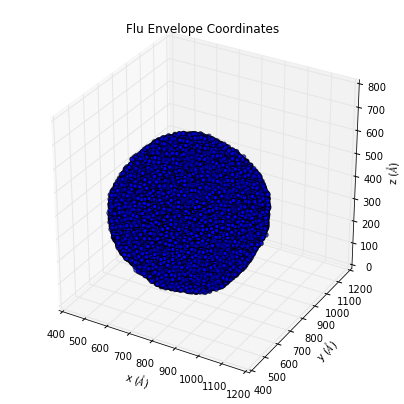

In [151]:
#load and plot the data:
fig_flu = plt.figure()
fig_flu.set_size_inches(7,7)
flu_coords = pickle.load(open('flu_coords.p','rb'))
ax = fig_flu.add_subplot(111,projection = '3d')
ax.scatter(flu_coords[...,0], flu_coords[...,1], flu_coords[...,2])
ax.set_xlabel('x ($\AA$)')
ax.set_ylabel('y ($\AA$)')
ax.set_zlabel('z ($\AA$)')
ax.set_xlim3d(400,1200)
ax.set_ylim3d(400,1200)
ax.set_zlim3d(0,800)
ax.set_title('Flu Envelope Coordinates')

(1404, 3, 3)
surface area estimate from Convex Hull: 1103521.423
surface area of roughly equivalent sphere: 1134557.42184
% reconstitution of sphere: 97.2644840849


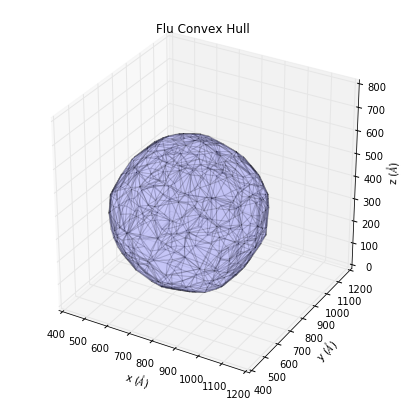

In [157]:
#calculate the 3D convex hull, plot the facets (triangles) of the hull, and sum together their areas to estimate the overall area of the viral surface
fig_flu_hull = plt.figure()
ax = fig_flu_hull.add_subplot(111, projection = '3d')
flu_hull = scipy.spatial.ConvexHull(flu_coords)
hull_triangle_coords = flu_hull.points[flu_hull.simplices]
flu_triangles = Poly3DCollection(hull_triangle_coords, alpha = 0.1)
ax.add_collection3d(flu_triangles)
ax.set_xlabel('x ($\AA$)')
ax.set_ylabel('y ($\AA$)')
ax.set_zlabel('z ($\AA$)')
ax.set_xlim3d(400,1200)
ax.set_ylim3d(400,1200)
ax.set_zlim3d(0,800)
fig_flu_hull.set_size_inches(7,7)
ax.set_title('Flu Convex Hull')

print hull_triangle_coords.shape
#use Heron's formula to calculate triangle surface areas
total_surface_area = 0
for triangle in hull_triangle_coords:
    first_vertex = triangle[0]
    second_vertex = triangle[1]
    third_vertex = triangle[2]
    a = scipy.spatial.distance.euclidean(first_vertex, second_vertex)
    b = scipy.spatial.distance.euclidean(second_vertex, third_vertex)
    c = scipy.spatial.distance.euclidean(third_vertex, first_vertex)
    s = (a + b + c) / 2. #semiperimeter
    triangle_area = math.sqrt(s * (s - a) * (s - b) * (s - c))
    total_surface_area += triangle_area
    
print 'surface area estimate from Convex Hull:', total_surface_area
#compare again surface area of roughly equivalent sphere
crude_radius = (flu_coords[...,2].max() - flu_coords[...,2].min()) / 2.
sphere_SA = 4. * math.pi * (crude_radius ** 2)
print 'surface area of roughly equivalent sphere:', sphere_SA
print '% reconstitution of sphere:', total_surface_area / sphere_SA * 100

Considering that flu isn't a perfect sphere, that % reconstitution of SA is an excellent indication that the calcluation was an excellent estimate.